In [ ]:
# CSV 파일 불러오기
# for vs code
file_path1 = 'data/Meteorological_2019_01.csv'
file_path2 = 'data/서울시_대기질_2019_01.csv'
xtest_path = 'data/Meteorological_2020_01.csv'
ytest_path = 'data/서울시_대기질_2020_01.csv'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install scikeras

In [3]:
# CSV 파일 불러오기
# for google colab
file_path1 = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2019_01.csv'
file_path2 = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2019_01.csv'
xtest_path = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2020_01.csv'
ytest_path = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2020_01.csv'

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from pandas.tseries.offsets import MonthEnd
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Lambda
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasRegressor
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

In [45]:
# User defined file import
import sys
sys.path.append('/content/drive/MyDrive/2024-2학기_연구참여/module')

from pre_process import (
    read_processing, time_processing, interpol_processing,
    scaling, log_scaling, boxcox_scaling, standard_scaling, quantile_scaling,
    latlon_to_grid, map_processing
)

from visualization import (
    plot_subplots, plot_ozone_maps
)

In [6]:
# 서울시의 위도와 경도 범위 설정
seoul_lat_min, seoul_lat_max = 37.4133, 37.7151  # 남북 경계 위도
seoul_lon_min, seoul_lon_max = 126.7341, 127.2693  # 동서 경계 경도

# 'Meteorological data' 측정 지역의 위도와 경도 정보
met_regions_data = {
    'region': ['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청', '마포', '서대문', '광진',
               '성북', '용산', '은평', '금천', '한강', '중구', '성동', '구로', '강북*', '남현', '관악', '영등포', '현충원'],
    'latitude': [37.49794, 37.47650, 37.53010, 37.51456, 37.55095, 37.51656, 37.66877, 37.65526, 37.57491, 37.59508, 37.56556,
                 37.56632, 37.57655, 37.53865, 37.58968, 37.53110, 37.60277, 37.45686, 37.52770, 37.56382, 37.56351, 37.49543,
                 37.646995, 37.46769, 37.47808, 37.52667, 37.50001],
    'longitude': [127.02761, 127.03250, 127.12587, 127.10662, 126.84953, 126.86658, 127.04744, 127.07712, 127.03963, 127.09368, 126.96691,
                  126.90131, 126.93784, 127.08237, 127.01667, 126.97960, 126.93040, 126.89576, 126.99818, 126.99760, 127.03722, 126.88740,
                  127.01371, 126.95818, 126.95143, 126.89636, 126.97422]
}

# DataFrame 생성
met_regions_df = pd.DataFrame(met_regions_data)
# row, col 행 추가
met_regions_df[['row', 'col']] = met_regions_df.apply(
    lambda r: pd.Series(
        latlon_to_grid(r['latitude'], r['longitude'], seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max)
        ),axis = 1
        )

# '서울시 대기질 데이터' 각 구의 위도와 경도 정보
air_regions_data = {
    'region': ['종로구', '용산구', '중구', '은평구', '서대문구', '마포구', '광진구', '노원구', '중랑구', '도봉구',
               '성북구', '성동구', '강북구', '동대문구', '동작구', '영등포구', '강서구', '관악구', '양천구', '구로구',
               '금천구', '강남구', '서초구', '강동구', '송파구'],
    'latitude': [37.573050, 37.531100, 37.563820, 37.602770, 37.576550, 37.566320, 37.538650, 37.655260, 37.595080, 37.668770,
                 37.589680, 37.563510, 37.646995, 37.574910, 37.512410, 37.526670, 37.550950, 37.478080, 37.516560, 37.495430,
                 37.456860, 37.497940, 37.476500, 37.530100, 37.514560],
    'longitude': [126.979340, 126.979600, 126.997600, 126.930400, 126.937840, 126.901310, 127.082370, 127.077120, 127.093680, 127.047440,
                  127.016670, 127.037220, 127.013710, 127.039630, 126.941040, 126.896360, 126.849530, 126.951430, 126.866580, 126.887400,
                  126.895760, 127.027610, 127.032500, 127.125870, 127.106620]
}

# DataFrame 생성
air_regions_df = pd.DataFrame(air_regions_data)
# row, col 행 추가
air_regions_df[['row', 'col']] = air_regions_df.apply(
    lambda r: pd.Series(
        latlon_to_grid(r['latitude'], r['longitude'], seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max)
        ),axis = 1
        )

In [7]:
# 변수 초기화
time_size = 3
grid_size = 32
feature_cols = ['기온(°C)']
n_features = len(feature_cols)
grid_data = np.zeros((744, time_size, grid_size, grid_size, n_features+1))
label_grid_data = np.zeros((744, 1, grid_size, grid_size, 1))
time_stamp = np.empty(744, dtype='datetime64[m]')

# Data PreProcessing
met_data, air_quality_data = read_processing(file_path1, file_path2)
time_processing(met_data, air_quality_data)
met_data = interpol_processing(met_data, feature_cols)
#scaling
x_train_scaler = scaling(met_data, feature_cols) # scaling
y_qt_scaler = quantile_scaling(air_quality_data, ['오존(ppm)'])
# y_sd_scaler = standard_scaling(air_quality_data,['오존(ppm)'])
# y_train_lambda, y_train_shift = boxcox_scaling(air_quality_data, ['오존(ppm)'])
y_train_scaler = scaling(air_quality_data, ['오존(ppm)']) # scaling

# mapping
map_processing(met_data, air_quality_data, grid_data, label_grid_data, time_stamp,
               feature_cols, met_regions_df, air_regions_df)
label_grid_data = label_grid_data.reshape(label_grid_data.shape[0],-1)

2019-01-01 00:00:00 2019-01-31 23:00:00


In [8]:
# loading test_data
te_grid_data = np.zeros((744, time_size, grid_size, grid_size, n_features+1))
te_label_grid_data = np.zeros((744, 1, grid_size, grid_size, 1))
te_time_stamp = np.empty(744, dtype='datetime64[m]')

# Data PreProcessing
te_met_data, te_air_quality_data = read_processing(xtest_path, ytest_path)
time_processing(te_met_data, te_air_quality_data)
te_met_data = interpol_processing(df=te_met_data, cols=feature_cols)
te_met_data[feature_cols] = x_train_scaler.transform(te_met_data[feature_cols]) # scaling
te_air_quality_data[['오존(ppm)']] = y_qt_scaler.transform(te_air_quality_data[['오존(ppm)']])
# te_air_quality_data[['오존(ppm)']] = y_sd_scaler.transform(te_air_quality_data[['오존(ppm)']])
# te_air_quality_data['오존(ppm)'] = te_air_quality_data['오존(ppm)'] + y_train_shift
# te_air_quality_data['오존(ppm)'] = stats.boxcox(te_air_quality_data['오존(ppm)'], lmbda=y_train_lambda)
te_air_quality_data[['오존(ppm)']] = y_train_scaler.transform(te_air_quality_data[['오존(ppm)']]) # scaling

# Mapping
map_processing(te_met_data, te_air_quality_data, te_grid_data, te_label_grid_data, te_time_stamp, feature_cols, met_regions_df, air_regions_df)

# save test_data
xtest = te_grid_data
ytest = te_label_grid_data.reshape(te_label_grid_data.shape[0], -1)

2020-01-01 00:00:00 2020-01-31 23:00:00


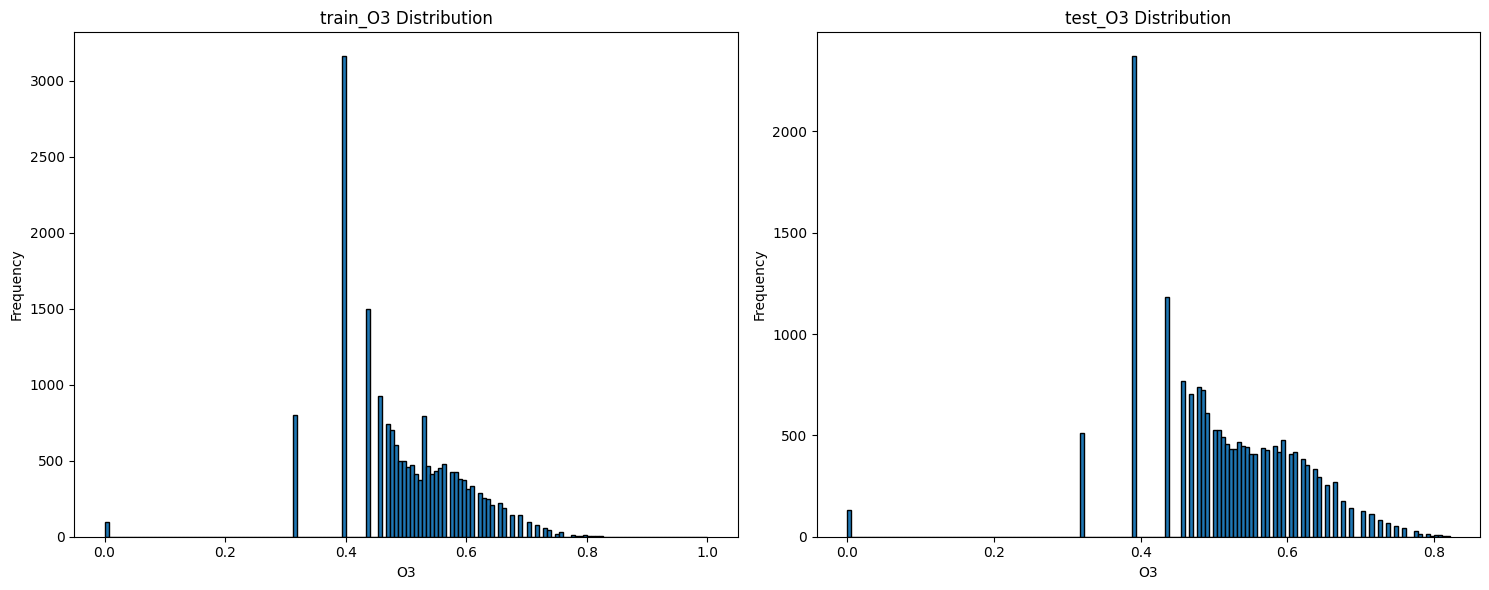

In [46]:
# 데이터 사양 정의
data_specs = [
    {
        'plot_type': 'hist',  # 히스토그램
        'data_list': [air_quality_data['오존(ppm)']],  # 첫 번째 데이터
        'bins': 150,  # 빈 수
        'alpha_list': [1.0],  # 투명도 (1.0은 불투명)
        'xlabel': 'O3',  # x축 레이블
        'ylabel': 'Frequency',  # y축 레이블
        'title': 'train_O3 Distribution',  # 서브플롯 제목
        'grid': False  # 그리드 없음
    },
    {
        'plot_type': 'hist',  # 히스토그램
        'data_list': [te_air_quality_data['오존(ppm)']],  # 두 번째 데이터
        'bins': 150,  # 빈 수
        'alpha_list': [1.0],  # 투명도 (1.0은 불투명)
        'xlabel': 'O3',  # x축 레이블
        'ylabel': 'Frequency',  # y축 레이블
        'title': 'test_O3 Distribution',  # 서브플롯 제목
        'grid': False  # 그리드 없음
    }
]

# 함수 호출하여 그래프 그리기
plot_subplots(data_specs, figsize=(15, 6))

In [10]:
# bit_mask 제작
def create_mask(df):
  mask = np.zeros((32,32), dtype=np.float32)
  r_lst = df['row'].tolist()
  c_lst = df['col'].tolist()
  for i in range(len(r_lst)):
    row = r_lst[i]
    col = c_lst[i]
    mask[row, col] = 1
  return mask


bit_mask = create_mask(air_regions_df)

In [11]:
class OzoneModel(nn.Module):
  def __init__(self, n_filter1, n_filter2, dense_units, mask_ts, n_channels):
    super(OzoneModel, self).__init__()

    self.conv1 = nn.Conv3d(
            in_channels=n_channels,
            out_channels=n_filter1,
            kernel_size=(2, 3, 3)
            )

    self.pool1 = nn.MaxPool3d(kernel_size=(1,2,2))

    self.conv2 = nn.Conv3d(
        in_channels = n_filter1,
        out_channels = n_filter2,
        kernel_size = (2,3,3)
    )

    self.pool2 = nn.MaxPool3d(kernel_size=(1,2,2))

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(in_features=n_filter2 * 1 * 6 * 6, out_features=dense_units)
    self.fc2 = nn.Linear(in_features=dense_units, out_features=32 * 32)


     # 마스크 등록 (평탄화된 형태)
    mask_ts = torch.tensor(mask_ts, dtype=torch.float32)
    mask_flat = mask_ts.view(-1)  # (1024,)
    self.register_buffer('mask', mask_flat)  # 마스크 등록

  def forward(self, x, onlyStation = True):
    x = F.relu(self.conv1(x))
    x = self.pool1(x)
    x = F.relu(self.conv2(x))
    x = self.pool2(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    if onlyStation:
      x = x * self.mask
    else:
      x = x

    return x

  def update_prediction(self, pred):
    self.prediction = pred

In [12]:
# 모델 학습 함수
def train_model(model, train_data, valid_data, criterion, optimizer, epochs, patience, device='cuda' if torch.cuda.is_available() else 'cpu'):
  model.to(device)

  # for early stopping
  best_val_loss = float('inf')
  best_val_metric = float('inf')
  epochs_no_improve = 0
  best_model_state = None

  for epoch in range(epochs):
    model.train()
    train_loss_per_batch = 0.0
    train_metric_per_batch = 0.0

    # training (per batch)
    for inputs, targets in train_data:
      inputs = inputs.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()
      pred = model(inputs)
      loss = criterion(pred, targets)
      loss.backward()
      optimizer.step()
      mae = torch.mean(torch.abs(pred-targets))

      train_loss_per_batch += loss.item()*inputs.size(0)
      train_metric_per_batch += mae.item()*inputs.size(0)

    train_loss = train_loss_per_batch / len(train_data.dataset)
    train_metric = train_metric_per_batch / len(train_data.dataset)


    # evaluate (per batch)
    model.eval()
    val_loss_per_batch = 0.0
    val_metric_per_batch = 0.0

    with torch.no_grad():
      for inputs, targets in valid_data:
        inputs = inputs.to(device)
        targets = targets.to(device)
        pred = model(inputs)
        loss = criterion(pred, targets)
        mae = torch.mean(torch.abs(pred-targets))

        val_loss_per_batch += loss.item() / inputs.size(0)
        val_metric_per_batch += mae.item() / inputs.size(0)

    val_loss = val_loss_per_batch / len(valid_data.dataset)
    val_metric = val_metric_per_batch / len(valid_data.dataset)

    print(f'Epoch {epoch+1}/{epochs} | Train HuberLoss: {train_loss:.4f} | Train MAE: {train_metric:.4f} | Val HuberLoss: {val_loss:.4f}| Val MAE: {val_metric:.4f}')

    # Early Stopping 체크 (둘 다 증가하지 않으면 학습을 멈춘다.)
    if val_loss < best_val_loss or val_metric < best_val_metric:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
        if val_metric < best_val_metric:
            best_val_metric = val_metric
        epochs_no_improve = 0
        best_model_state = model.state_dict()
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print('Early stopping!')
            break

  # 베스트 모델 로드
  if best_model_state is not None:
      model.load_state_dict(best_model_state)

  return model

In [13]:
# 모델 평가 함수
def evaluate_model(model, test_data, criterion, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()
    test_loss_per_batch = 0.0
    test_mae_per_batch = 0.0

    with torch.no_grad():
        for inputs, targets in test_data:
            inputs = inputs.to(device)
            targets = targets.to(device)

            pred = model(inputs)
            loss = criterion(pred, targets)
            mae = torch.mean(torch.abs(pred-targets))

            test_loss_per_batch += loss.item() * inputs.size(0)
            test_mae_per_batch += mae.item() * inputs.size(0)

    test_loss = test_loss_per_batch / len(test_data.dataset)
    test_mae = test_mae_per_batch / len(test_data.dataset)

    print(f'Test HuberLoss: {test_loss:.4f}, Test MAE: {test_mae:.4f}')

    return test_loss, test_mae


In [14]:
# 예측 수행 함수 정의
def predict(model, data_loader, onlyStation=True, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    model.eval()

    all_predictions = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch[0].to(device)  # TensorDataset의 경우 batch는 튜플 형태
            outputs = model(inputs, onlyStation=onlyStation)
            predictions = outputs.cpu().numpy()
            all_predictions.append(predictions)

    # 모든 배치의 예측을 하나의 배열로 합침
    all_predictions = np.concatenate(all_predictions, axis=0)
    return all_predictions

In [15]:
class maskedHuber(nn.Module):
    def __init__(self, mask, delta=1.0):
        super(maskedHuber, self).__init__()
        self.register_buffer('mask', mask)
        self.delta = delta

    def forward(self, preds, targets):
        diff = preds - targets
        valid_columns = (self.mask != 0)
        diff = diff[:, valid_columns]

        abs_diff = torch.abs(diff)

        # Huber loss 공식:
        # |diff| <= delta: 0.5 * diff^2
        # |diff| > delta: delta * |diff| - 0.5 * delta^2
        quadratic_part = torch.minimum(abs_diff, torch.tensor(self.delta, device=abs_diff.device))
        linear_part = abs_diff - quadratic_part

        huber = 0.5 * quadratic_part ** 2 + self.delta * linear_part
        return torch.mean(huber)


In [16]:
# 데이터 텐서로 변환 및 데이터로더 생성
def convertLoader(x, y=None, batch_size=16, shuffle=False):
    x = np.transpose(x, (0, 4, 1, 2, 3))

    # NumPy 배열을 PyTorch 텐서로 변환
    x_tensor = torch.tensor(x, dtype=torch.float32)

    if y is not None:
        y_tensor = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(x_tensor, y_tensor)
    else:
        dataset = TensorDataset(x_tensor)

    # DataLoader 생성
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

In [17]:
from sklearn.model_selection import TimeSeriesSplit
from IPython.display import clear_output

# 교차 검증을 통해 모델을 학습하는 함수
# 전역변수: bit_mask, n_features, ytrain, yvalid
def TrainML(xdata, ydata):

    # split 횟수
    n = 5

    # TimeSeriesSplit 설정
    tscv = TimeSeriesSplit(n_splits=n)

    # model list, score list 생성
    model_list = []
    # 교차 검증 동안 score를 저장
    train_S = np.zeros((n, 2))
    valid_S = np.zeros((n, 2))
    # prediction 저장
    train_P = []
    valid_P = []

    # 교차 검증
    for fold, (train_idx, valid_idx) in enumerate(tscv.split(xdata)):
      xtrain, xvalid = xdata[train_idx], xdata[valid_idx]
      ytrain, yvalid = ydata[train_idx], ydata[valid_idx]

      # data to loader
      train_loader = convertLoader(xtrain, ytrain)
      valid_loader = convertLoader(xvalid, yvalid)

      # model 객체 생성, train
      model = OzoneModel(n_filter1 = 32, n_filter2 = 128, dense_units=64, mask_ts = bit_mask, n_channels = n_features+1)
      trained_model = train_model(
          model = model,
          train_data = train_loader,
          valid_data = valid_loader,
          criterion = maskedHuber(mask=model.mask, delta=0.35),
          optimizer = Adam(model.parameters(), lr=1e-4),
          epochs = 300,
          patience = 10
      )

      # 학습된 model 인스턴스 model_list에 추가
      model_list.append(model)

      # 얻은 score list에 추가(score[0]: HuberLoss, score[1]: MAE)
      train_score = evaluate_model(model = trained_model, test_data=train_loader, criterion=maskedHuber(mask=model.mask, delta=0.35))
      valid_score = evaluate_model(model = trained_model, test_data=valid_loader, criterion=maskedHuber(mask=model.mask, delta=0.35))
      train_S[fold, :] = train_score
      valid_S[fold, :] = valid_score

      # clear command line
      clear_output(wait=True)


    # 결과 출력
    print(f"Mean Train MAE --> {np.mean(train_S, axis = 0)[1]:.4f}")
    print(f"Mean Validation MAE --> {np.mean(valid_S, axis = 0)[1]:.4f}")

    return model_list

In [18]:
# 예측 수행
def PredictML(model_list, xdata, onlyStation=True):
	# Pred_list 선언
	n_model = len(model_list)
	n_data = xdata.shape[0]
	pred_list = np.zeros((n_model, n_data, 1024))

	data_loader = convertLoader(xdata)

	for idx, model in enumerate(model_list):
		pred_list[idx] = predict(model, data_loader, onlyStation=onlyStation)

	prediction = np.mean(pred_list, axis = 0)

	return prediction

In [19]:
# 평가 수행
def EvaluateML(model_list, xdata, ydata):
  n_model = len(model_list)
  # 교차 검증 동안 score를 저장
  test_S = np.zeros((n_model,2))

  # convert loader
  test_loader = convertLoader(xdata, ydata)

  for idx, model in enumerate(model_list):
    print(f"Model{idx+1} Prediction: ")
    test_S[idx, :] = evaluate_model(model = model, test_data=test_loader, criterion=maskedHuber(mask=model.mask, delta=0.35))

  print(f"Mean Test MAE --> {np.mean(test_S, axis = 0)[1]:.4f}")

In [20]:
# 학습 실행과정
model_list = TrainML(grid_data, label_grid_data)

Mean Train MAE --> 0.0007
Mean Validation MAE --> 0.0008


In [21]:
EvaluateML(model_list, xtest, ytest)

Model1 Prediction: 
Test HuberLoss: 0.0036, Test MAE: 0.0014
Model2 Prediction: 
Test HuberLoss: 0.0029, Test MAE: 0.0013
Model3 Prediction: 
Test HuberLoss: 0.0021, Test MAE: 0.0010
Model4 Prediction: 
Test HuberLoss: 0.0018, Test MAE: 0.0009
Model5 Prediction: 
Test HuberLoss: 0.0017, Test MAE: 0.0009
Mean Test MAE --> 0.0011


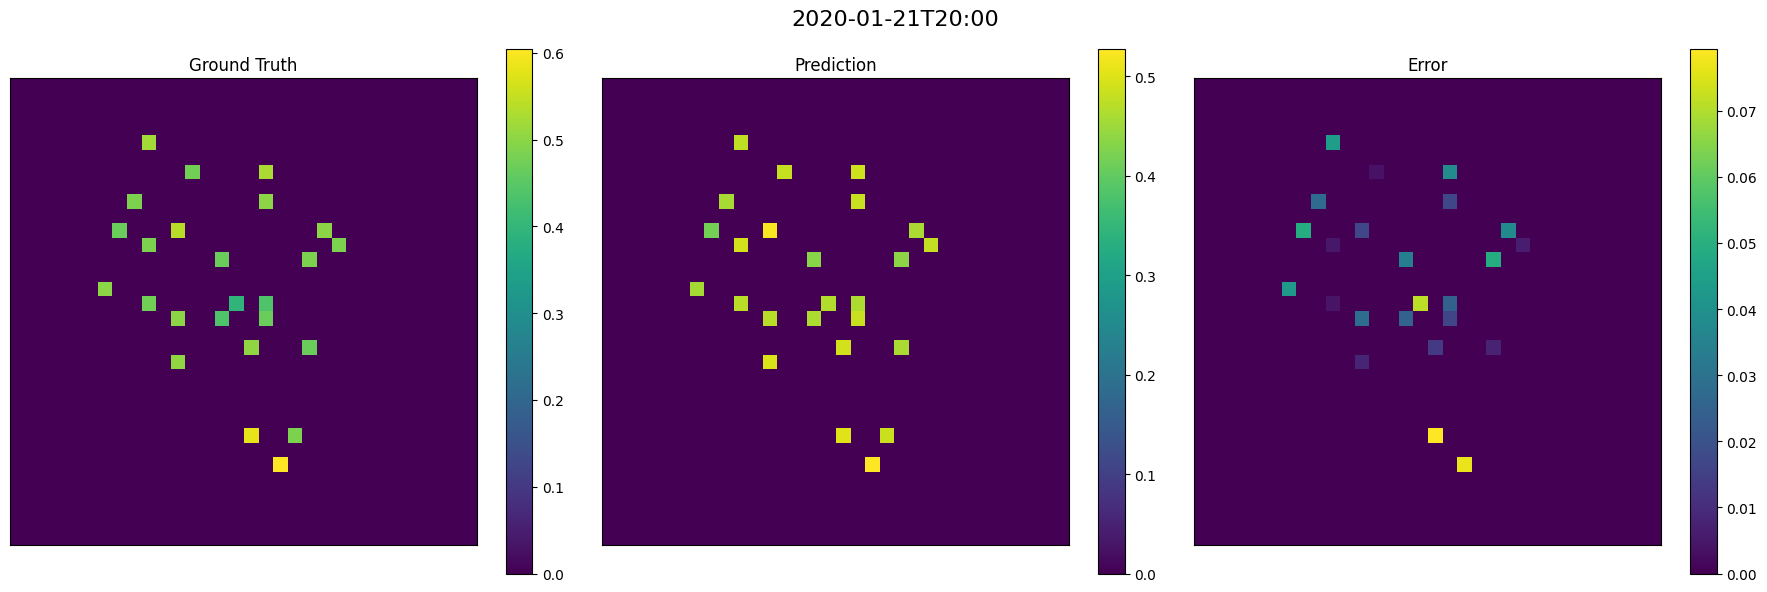

In [33]:
# train prediction 시각화
xtrain = grid_data
ytrain = label_grid_data
train_pred = PredictML(model_list, xtrain)
plot_ozone_maps(index=500, g_data=ytrain, prediction = train_pred, time_stamp = te_time_stamp) #추후 train의 timestamp가 필요하다.

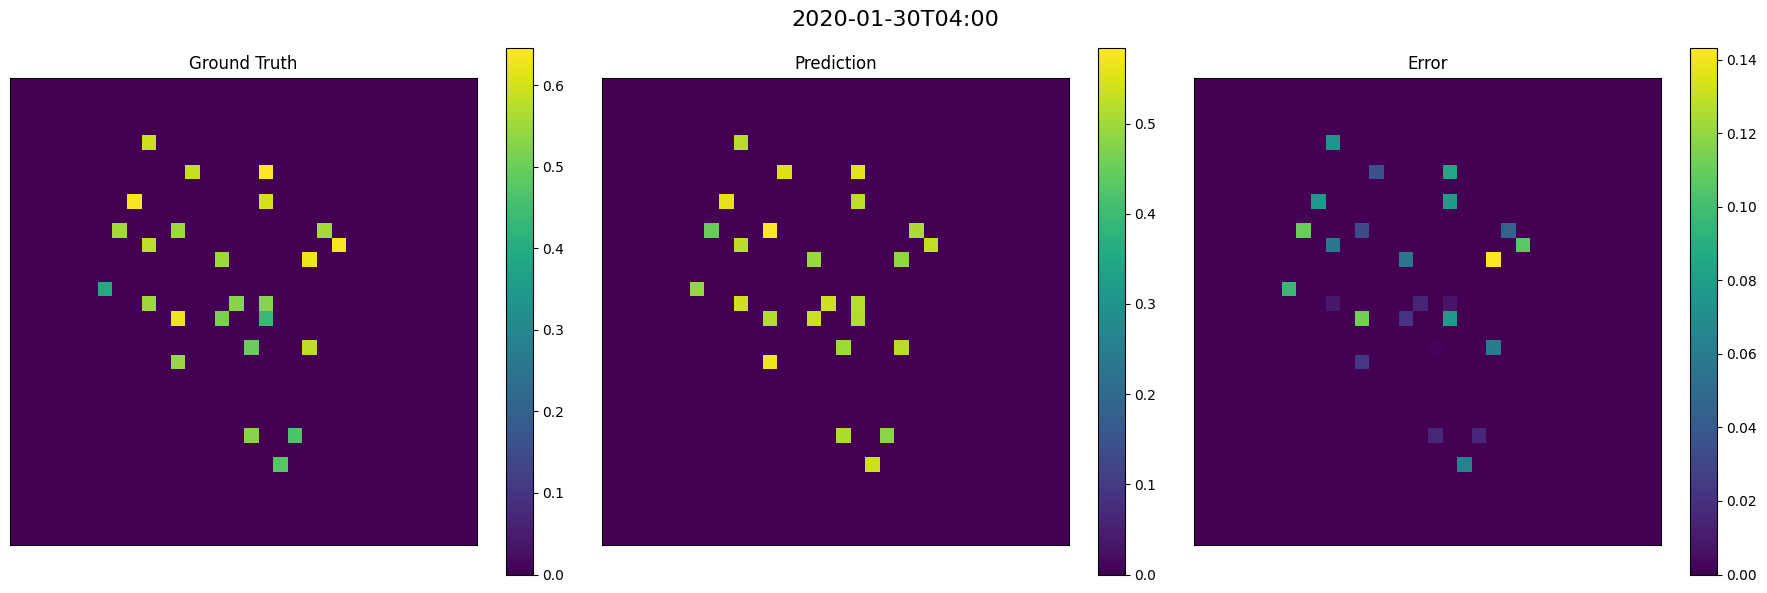

In [34]:
# test prediction 시각화
test_pred = PredictML(model_list, xtest)
plot_ozone_maps(index=700, g_data=ytest, prediction=test_pred, time_stamp = te_time_stamp)

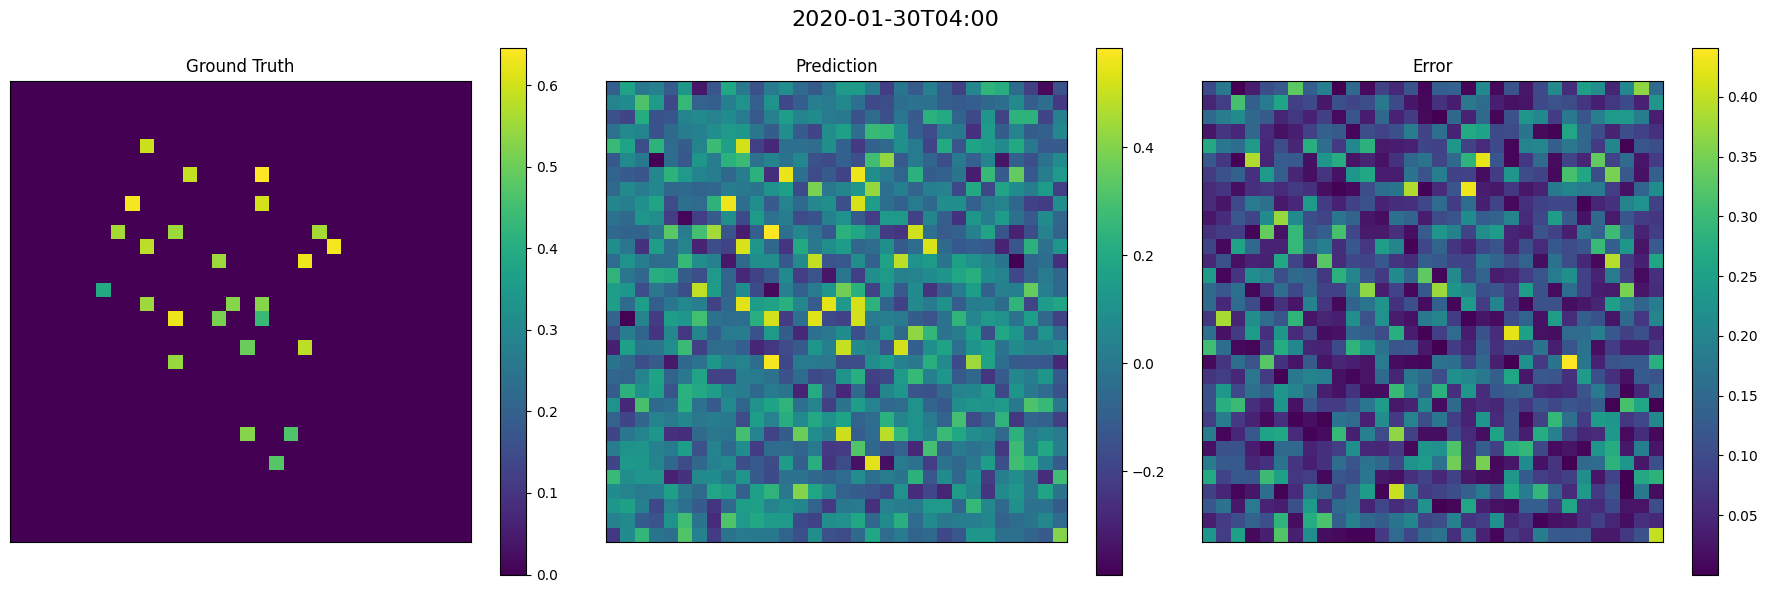

In [35]:
# test prediction 시각화 (not only station)
test_pred_all = PredictML(model_list, xtest, onlyStation=False)
plot_ozone_maps(index=700, g_data=ytest, prediction=test_pred_all, time_stamp = te_time_stamp)

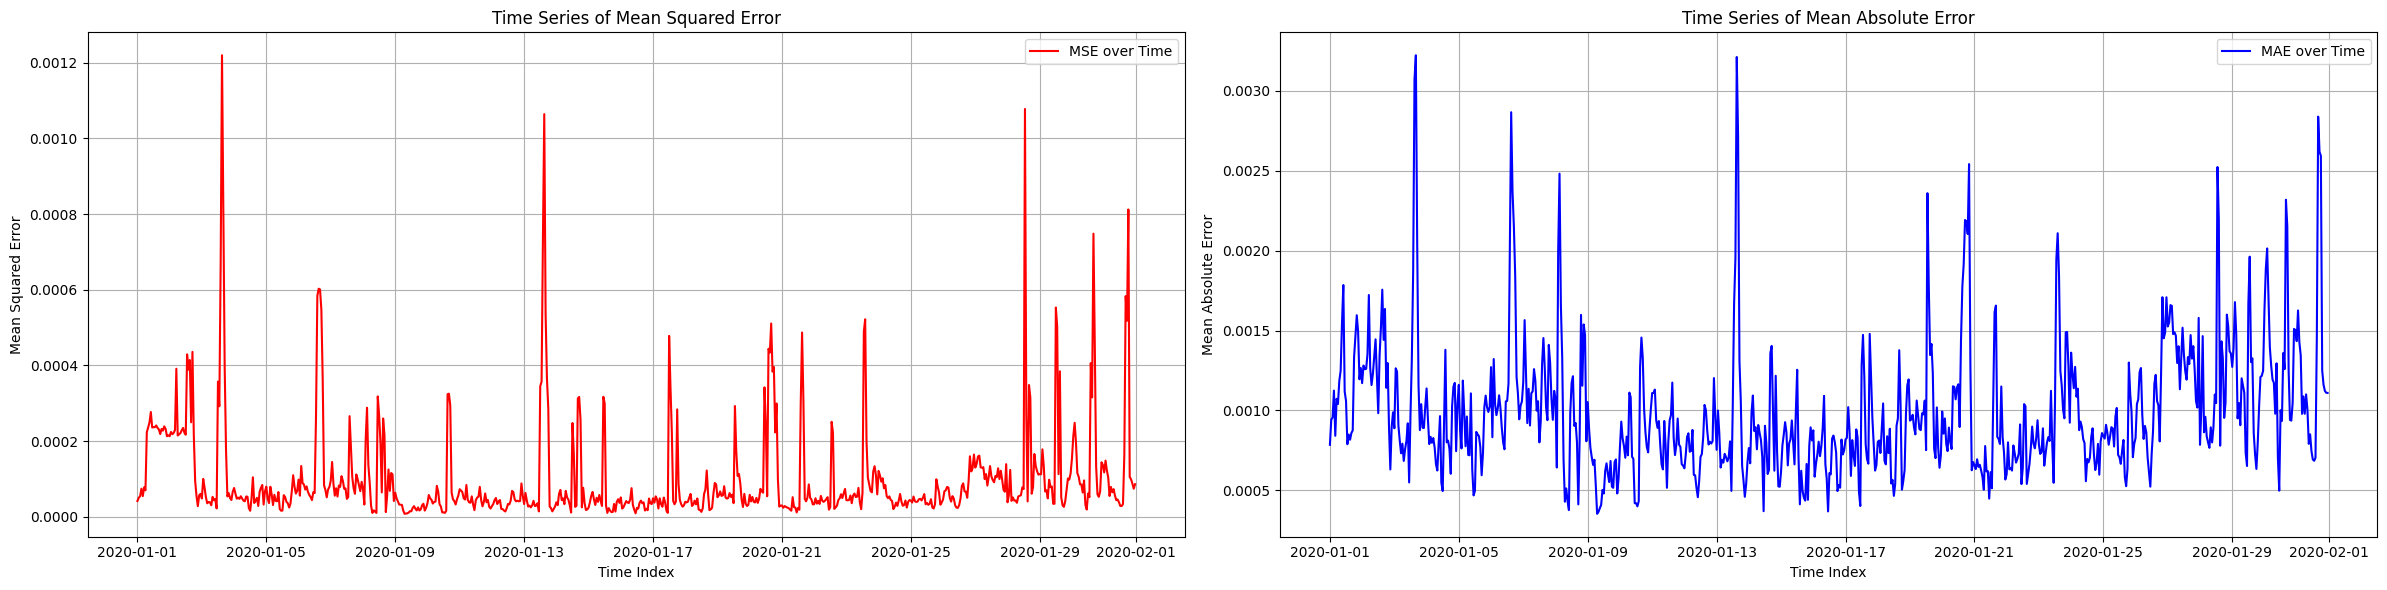

In [41]:
# 데이터 준비
gt = ytest.reshape(-1, grid_size, grid_size)
pdc = test_pred
pdc = pdc.reshape(-1,32,32)
mse_per_time = np.mean((gt - pdc) ** 2, axis=(1, 2))   # 시간별 MSE 계산 (num_samples,)
mae_per_time = np.mean(np.abs(gt - pdc), axis=(1, 2))  # 시간별 MAE 계산 (num_samples,)

data_specs = [
    {
        'plot_type': 'line',  # 라인 플롯
        'x': te_time_stamp,   # x축 데이터 (시간 인덱스)
        'y_list': [mse_per_time],  # y축 데이터 (MSE)
        'labels': ['MSE over Time'],  # 레이블 (legend에 표시될 텍스트)
        'colors': ['red'],  # 선 색상
        'xlabel': 'Time Index',  # x축 레이블
        'ylabel': 'Mean Squared Error',  # y축 레이블
        'title': 'Time Series of Mean Squared Error',  # 서브플롯 제목
        'grid': True  # 그리드 표시
    },
    {
        'plot_type': 'line',  # 라인 플롯
        'x': te_time_stamp,   # x축 데이터 (시간 인덱스)
        'y_list': [mae_per_time],  # y축 데이터 (MAE)
        'labels': ['MAE over Time'],  # 레이블 (legend에 표시될 텍스트)
        'colors': ['blue'],  # 선 색상
        'xlabel': 'Time Index',  # x축 레이블
        'ylabel': 'Mean Absolute Error',  # y축 레이블
        'title': 'Time Series of Mean Absolute Error',  # 서브플롯 제목
        'grid': True  # 그리드 표시
    }
]

# 그래프 그리기
plot_subplots(data_specs, figsize=(24, 6))


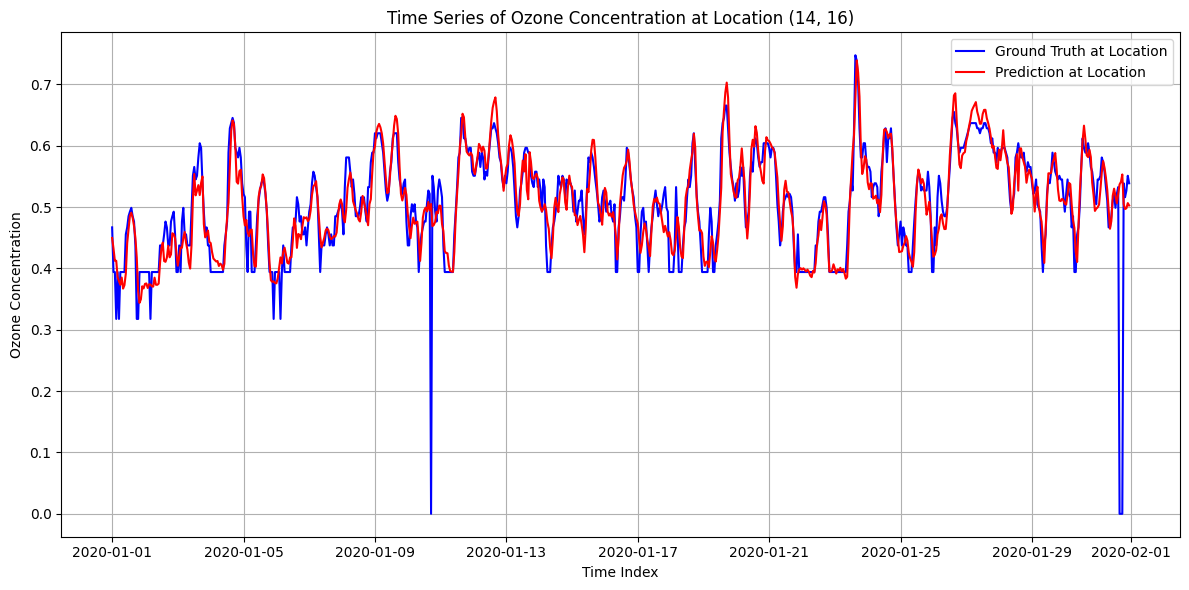

In [44]:
# 한 지역을 고정하고 시간에 따른 분포 관찰
x_coord = 14  # 가로 위치 (0부터 31까지)
y_coord = 16 # 세로 위치 (0부터 31까지)

# 시간에 따른 특정 위치의 오존 농도 추출
gt_at_location = gt[:, y_coord, x_coord]  # (num_samples,)
pred_at_location = pdc[:, y_coord, x_coord]  # (num_samples,)

# data_specs 정의 (라인 플롯)
data_specs = [
    {
        'plot_type': 'line',  # 라인 플롯
        'x': te_time_stamp,   # x축 데이터 (시간 인덱스)
        'y_list': [gt_at_location, pred_at_location],  # y축 데이터 (Ground Truth & Prediction)
        'labels': ['Ground Truth at Location', 'Prediction at Location'],  # 레이블
        'colors': ['blue', 'red'],  # 선 색상
        'xlabel': 'Time Index',  # x축 레이블
        'ylabel': 'Ozone Concentration',  # y축 레이블
        'title': f'Time Series of Ozone Concentration at Location ({x_coord}, {y_coord})',  # 서브플롯 제목
        'grid': True  # 그리드 표시
    }
]

# 그래프 그리기
plot_subplots(data_specs, figsize=(12, 6))

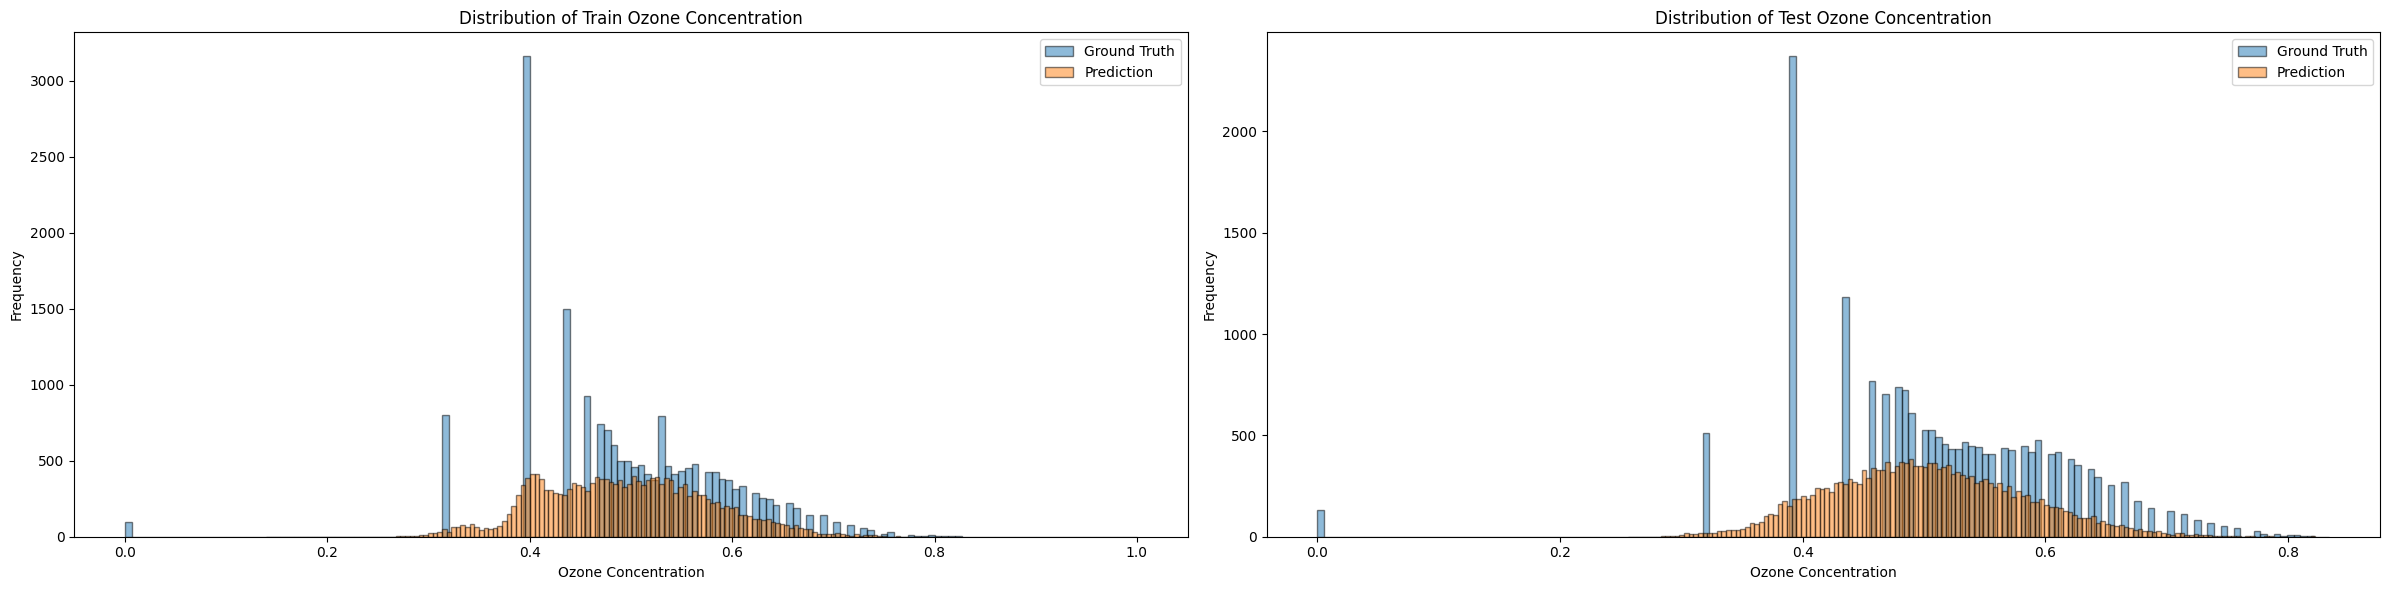

In [42]:
# 전체 시간의 오존 값의 분포 비교 (관측소가 있는 지점만)
# 관측소가 있는 지점만 마스킹, flatten
def process_data(y, pred, mask):
    y_masked = y[:, mask!=0]
    pred_masked = pred[:, mask!=0]
    y_flat = y_masked.flatten()
    pred_flat = pred_masked.flatten()

    return y_flat, pred_flat

# mask, prediction
mask = model_list[0].mask

# mask가 CUDA 텐서인 경우 CPU로 이동
if mask.is_cuda:
    mask = mask.cpu()

# data processing
gt_train_flat, pred_train_flat = process_data(ytrain, train_pred, mask)
gt_test_flat, pred_test_flat = process_data(ytest, test_pred, mask)

# data_specs 정의 (히스토그램)
data_specs = [
    {
        'plot_type': 'hist',  # 히스토그램
        'data_list': [gt_train_flat, pred_train_flat],  # 두 개의 데이터
        'bins': 150,  # 빈 수
        'alpha_list': [0.5, 0.5],  # 투명도
        'labels': ['Ground Truth', 'Prediction'],  # 레이블
        'xlabel': 'Ozone Concentration',  # x축 레이블
        'ylabel': 'Frequency',  # y축 레이블
        'title': 'Distribution of Train Ozone Concentration',  # 서브플롯 제목
        'grid': False  # 그리드 표시 여부
    },
    {
        'plot_type': 'hist',  # 히스토그램
        'data_list': [gt_test_flat, pred_test_flat],  # 두 개의 데이터
        'bins': 150,  # 빈 수
        'alpha_list': [0.5, 0.5],  # 투명도
        'labels': ['Ground Truth', 'Prediction'],  # 레이블
        'xlabel': 'Ozone Concentration',  # x축 레이블
        'ylabel': 'Frequency',  # y축 레이블
        'title': 'Distribution of Test Ozone Concentration',  # 서브플롯 제목
        'grid': False  # 그리드 표시 여부
    }
]

# 그래프 그리기
plot_subplots(data_specs, figsize=(24, 6))